In [1]:
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear, Module, ModuleList
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from torch_frame.data import Dataset, DataLoader
from torch_frame import TensorFrame, stype
from torch_frame.nn.conv import TabTransformerConv
from torch_frame.nn.encoder import (
    EmbeddingEncoder,
    LinearEncoder,
    StypeWiseFeatureEncoder,
)

def prepare_dataset(df):
    # For categorical features, replace NA with "Missing"
    categorical_columns = df.select_dtypes(include=['object']).columns
    for key in categorical_columns:
        df[key] = df[key].astype('category').cat.add_categories("Missing").fillna("Missing")
    # categorical_columns = df.select_dtypes(include=['category']).columns
    return df

In [2]:
train_file_path = "data/house-prices/train.csv"
dataset_df = pd.read_csv(train_file_path)
dataset_df = dataset_df.drop('Id', axis=1)
target_column = 'SalePrice'
dataset_df = prepare_dataset(dataset_df)
col_to_stype = {key: stype.categorical for key in dataset_df.select_dtypes(include=['category']).columns.to_list()}
col_to_stype.update({key: stype.numerical for key in dataset_df.select_dtypes(exclude=['category']).columns.to_list()})
dataset = Dataset(dataset_df, col_to_stype=col_to_stype, target_col=target_column)
dataset.materialize()

dataset.tensor_frame

TensorFrame(
  num_cols=79,
  num_rows=1460,
  categorical (43): ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities'],
  numerical (36): ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', '

In [3]:
class ExampleTransformer(Module):
    def __init__(
        self,
        channels, out_channels, num_layers, num_heads,
        col_stats, col_names_dict,
    ):
        super().__init__()
        self.encoder = StypeWiseFeatureEncoder(
            out_channels=channels,
            col_stats=col_stats,
            col_names_dict=col_names_dict,
            stype_encoder_dict={
                stype.categorical: EmbeddingEncoder(),
                stype.numerical: LinearEncoder()
            },
        )
        self.convs = ModuleList([
            TabTransformerConv(
                channels=channels,
                num_heads=num_heads,
            ) for _ in range(num_layers)
        ])
        self.decoder = Linear(channels, out_channels)

    def forward(self, tf: TensorFrame) -> Tensor:
        x, _ = self.encoder(tf)
        for conv in self.convs:
            x = conv(x)
        out = self.decoder(x.mean(dim=1))
        return out

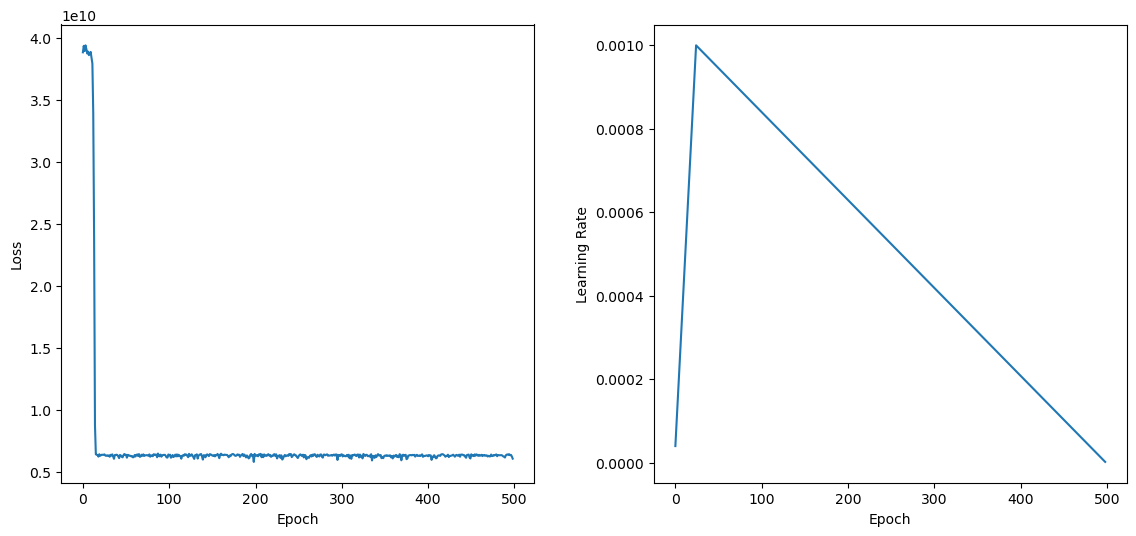

In [5]:
stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: LinearEncoder(),
}

device = 'cuda:5'

from torch_frame.nn.models.ft_transformer import FTTransformer

# model = FTTransformer(
#     channels=16,
#     out_channels=1,
#     num_layers=2,
#     col_stats=dataset.col_stats,
#     col_names_dict=dataset.tensor_frame.col_names_dict,
#     stype_encoder_dict=stype_encoder_dict,
# ).to(device)

model = ExampleTransformer(
    channels=32,
    out_channels=1,
    num_layers=2,
    num_heads=8,
    col_stats=dataset.col_stats,
    col_names_dict=dataset.tensor_frame.col_names_dict,
).to(device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Initial setup for the first plot
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Initial setup for the second plot
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

num_epochs = 500
batch_size = 128
steps_per_epoch = len(dataset) // batch_size
num_steps = num_epochs * steps_per_epoch
warmup_steps = int(0.05 * num_steps)

train_loader = DataLoader(dataset.tensor_frame, batch_size=batch_size,
                          shuffle=True, drop_last=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-5)
# Setup the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps,  # Example values
                                            num_training_steps=num_steps)

loss_list = [None] * num_epochs
lr_list = [None] * num_epochs
for epoch in range(num_epochs):
    # print('===Epoch {}==='.format(epoch))
    total_loss = 0
    total_bsz = 0
    for tf in train_loader:
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.mse_loss(pred, tf.y)
        bsz = len(tf.y)
        total_loss += loss.item() * bsz
        total_bsz += bsz
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    # print('average loss = {}'.format(total_loss / total_bsz))
    loss_list[epoch] = total_loss / total_bsz
    lr_list[epoch] = optimizer.param_groups[0]['lr']
    ax1.cla()
    ax2.cla()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax1.plot(loss_list[:epoch])
    ax2.plot(lr_list[:epoch])
    plt.tight_layout(pad=3.0)
    display(fig)
    clear_output(wait=True)

In [6]:
model.forward(dataset.tensor_frame.to(device))

tensor([[181061.2031],
        [180914.9688],
        [181076.4375],
        ...,
        [181203.7188],
        [180858.0000],
        [180872.4375]], device='cuda:5', grad_fn=<AddmmBackward0>)

In [25]:
test_file_path = "data/house-prices/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_data = prepare_dataset(test_data)
col_to_stype = {key: stype.categorical for key in test_data.select_dtypes(include=['category']).columns.to_list()}
col_to_stype.update({key: stype.numerical for key in test_data.select_dtypes(exclude=['category']).columns.to_list()})
test_dataset = Dataset(test_data, col_to_stype=col_to_stype)
test_dataset.materialize()

model(test_dataset.tensor_frame.to(device))

tensor([[-0.0792],
        [-0.2398],
        [-0.0740],
        ...,
        [-0.6281],
        [-0.3431],
        [-0.5273]], device='cuda:5', grad_fn=<AddmmBackward0>)